# Processing

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Load dataset

In [2]:
import boto3
from boto3 import session
import os

key_id = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
bucket_name = os.environ.get("AWS_S3_BUCKET")
s3_endpoint = os.environ.get("AWS_S3_ENDPOINT")

s3_client = boto3.client("s3", aws_access_key_id=key_id, aws_secret_access_key=secret_key, endpoint_url=s3_endpoint)

In [3]:
s3_client.download_file(bucket_name, "training.1600000.processed.noemoticon.csv", 'train.csv')

In [4]:
dataset_path = "./"
train_data_fb = "train.csv"
df=pd.read_csv(dataset_path + "/" + train_data_fb, encoding="latin_1",  names=['target', 'ids', 'date', 'flag', 'user', 'text'])
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Data quality

### General

In [5]:
print(f"Dataframe shape: {df.shape}")
print(f"Columns: {df.columns}")

Dataframe shape: (1600000, 6)
Columns: Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
df['flag'].value_counts()

flag
NO_QUERY    1600000
Name: count, dtype: int64

Flag column does not contain any useful information. Let's drop this feature.

In [8]:
df = df.drop("flag", axis = 1)

Checking the labels. Convert them to binary.

In [9]:
df['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [10]:
df["target"] = df["target"].apply(lambda x: 0 if x == 0 else 1)

In [11]:
df

,target,ids,date,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Empty tweet

In [12]:
empty_tweets = df[df['text'].apply(lambda x: len(x)==0)]
print(f"Number of empty tweets: {len(empty_tweets.index)}")

Number of empty tweets: 0


### Senstive data

In [14]:
df = df.drop("user", axis = 1)

In [15]:
import re
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
pii_users = df['text'].apply(lambda x: re.findall(userPattern, x)).apply(lambda x: ' '.join(x)).values
pii_users = [u for u in pii_users if u]



### Duplicated

Ensure there is no duplicated row

In [16]:
assert not any(df.duplicated())

Check duplicated in text content

In [17]:
duplicated_text = df[df['text'].duplicated(keep=False)]['text'].sort_values()
df.iloc[duplicated_text.index]

,target,ids,date,text
271472,0,1990023076,Mon Jun 01 03:37:19 PDT 2009,David must be hospitalized for five days end...
271505,0,1990029536,Mon Jun 01 03:38:42 PDT 2009,David must be hospitalized for five days end...
1132076,1,1975956610,Sat May 30 16:16:11 PDT 2009,bathroom is clean..... now on to more enjoya...
1132074,1,1975956536,Sat May 30 16:16:11 PDT 2009,bathroom is clean..... now on to more enjoya...
540159,0,2199656747,Tue Jun 16 17:49:00 PDT 2009,#IMISSCATH #IMISSCATH #IMISSCATH #IMISSCATH #...
...,...,...,...,...
458170,0,2071810977,Sun Jun 07 19:57:37 PDT 2009,"zofran is not making this work day any easier,..."
464810,0,2175206707,Mon Jun 15 00:21:43 PDT 2009,~ get SUICIDE !!
463926,0,2175018052,Sun Jun 14 23:52:55 PDT 2009,~ get SUICIDE !!
1170868,1,1980423297,Sun May 31 06:42:03 PDT 2009,~~~X0X0~~~!!!X0X0!!! I love you!!! &amp;...


We notice duplicated tweets. We also see inconsistency in labels such as index 1170868 and 238478. Let's first drop all row that contains the same text and a different target.

In [18]:
inconsistency = df.groupby(df['text'], as_index=False)['target'].mean()
inconsistency_filter = inconsistency['target'].apply(lambda x: x not in [0,1])
inconsistency_tweets_unique = inconsistency[inconsistency_filter]['text']
print(f"Number of unique inconsistent tweets: {inconsistency_tweets_unique.count()}")

Number of unique inconsistent tweets: 2225


In [19]:
inconsistency_tweets = df[df.apply(lambda x: x['text'] in inconsistency_tweets_unique.values, axis=1)]
print(inconsistency_tweets.sort_values(by="text").head(n=10).to_string())
print(f"Total number of inconsistent tweets: {len(inconsistency_tweets.index)}")

         target         ids                          date                                                                                                                                      text
385331        0  2053581479  Sat Jun 06 05:02:55 PDT 2009                                                         British weather is back i see! Oh well Birtney, london and ciaraaaa in 5 dayssss 
1394129       1  2053581479  Sat Jun 06 05:02:55 PDT 2009                                                         British weather is back i see! Oh well Birtney, london and ciaraaaa in 5 dayssss 
1272390       1  2000686472  Mon Jun 01 22:42:09 PDT 2009                                                                                                                                I love you
507399        0  2188890860  Mon Jun 15 22:46:53 PDT 2009                                                                                                                                I love you
184535        0  196

We finally drop the inconsistent tweets

In [20]:
df = df.drop(inconsistency_tweets.index)

Then we drop duplicated text

In [21]:
df = df.drop_duplicates("text")

Let's check the label repartition

In [22]:
df["target"].value_counts()

target
1    791281
0    787960
Name: count, dtype: int64

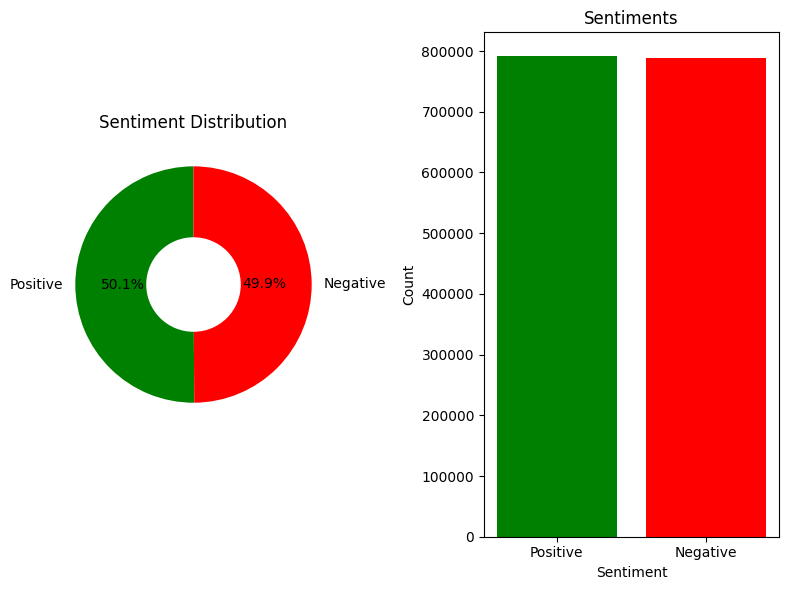

In [23]:
df_target = (
    df['target'].value_counts().to_frame(name='count').reset_index()
    .rename(columns={'index': 'target'})
)

# Convert 'target' to numeric (1 for positive, 0 for negative)
df_target['target'] = df_target['target'].replace(4, 1)

# Calculate user counts for positive and negative tweets
positive_tweets = df_target[df_target['target'] == 1]['count'].sum()
negative_tweets = df_target[df_target['target'] == 0]['count'].sum()

#sunplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

# Pie Chart for Sentiment Distribution
ax1.pie(
    [positive_tweets, negative_tweets],
    labels=['Positive', 'Negative'],
    autopct="%1.1f%%",
    startangle=90,
    colors=['green', 'red'],
    wedgeprops=dict(width=0.6)
)
ax1.set_title('Sentiment Distribution')

# Bar Chart for User Counts
ax2.bar(['Positive', 'Negative'], [positive_tweets, negative_tweets], color=['green', 'red'])
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Count')
ax2.set_title('Sentiments')

# Tight layout for better overall plot arrangement
plt.tight_layout()

# Display the combined plot
plt.show()


The label are well distributed enough.

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /opt/app-
[nltk_data]     root/src/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

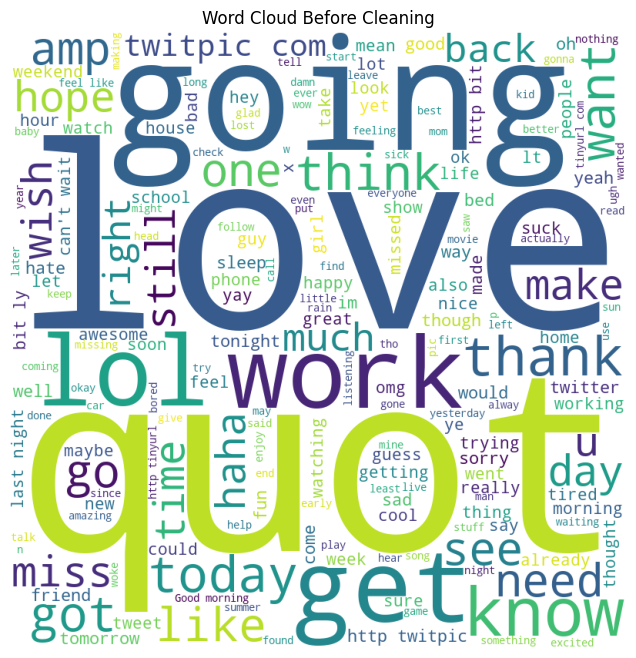

In [25]:
import pandas as pd 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nltk.corpus import stopwords

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=800, 
                          background_color='white', 
                          stopwords=stop_words, 
                          min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.title(title)
    plt.show()
    
raw_drity_text = ' '.join(df['text'])
generate_word_cloud(raw_drity_text, 'Word Cloud Before Cleaning')


In [26]:
import string
from collections import Counter

raw_drity_text_counter = Counter(raw_drity_text)
non_letters_characters = raw_drity_text_counter.keys() - list(string.ascii_letters)
print(non_letters_characters)
print(f"Size of non_letters_characters {len(non_letters_characters)}")

{'£', ':', 'Ñ', '\x86', ',', '²', '¤', '\x96', '¯', 'ì', '¢', 'Ê', '°', '6', 'í', '\x98', '3', 'á', '\xad', '\x9b', '/', '4', 'Â', '!', '\x91', '\x8b', 'Ò', '\x9c', '×', '\x89', 'ï', 'º', '{', '·', 'è', '.', '\x9e', '\x85', 'Í', '¼', '¶', '¥', '9', 'Ç', 'â', '%', '®', '\x97', '½', '\x9a', 'Ä', '\x8c', 'Ì', '»', 'ª', '~', 'ä', 'ë', '\x82', '(', '±', 'Ó', '1', '2', 'Ë', '+', '\x99', 'î', "'", '5', '³', '=', '\\', 'å', 'é', 'µ', 'Ã', '8', '¨', '¬', '«', '?', '7', '^', '\x88', 'Å', '\x95', 'Æ', '´', '\xa0', '-', 'ß', '\x87', '&', '¿', 'È', '\x92', '\x84', '#', '\x8a', 'ç', 'Û', '¦', ']', '`', 'æ', '0', '¸', '@', 'Ø', '\x8e', '©', 'Ð', ';', 'É', '§', '$', 'ê', '¡', '[', '\x93', '\x94', '\x80', ')', '}', '\t', '*', '¹', 'ã', '¾', '|', 'Ï', '\x7f', '\x83', 'Ù', 'Î', 'Ú', '_', 'à', ' ', '\x9f'}
Size of non_letters_characters 141


There are plenty of special characters. We need to clean them

In [27]:
# Function to plot bar plot of word frequencies
def plot_word_frequencies(text, title):
    word_freq = nltk.FreqDist(text.split())
    common_words = word_freq.most_common(20)
    words, freqs = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(freqs), palette='viridis')
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
# Step 3: Plot bar plots of word frequencies


/tmp/ipykernel_349/2346538814.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette='viridis')


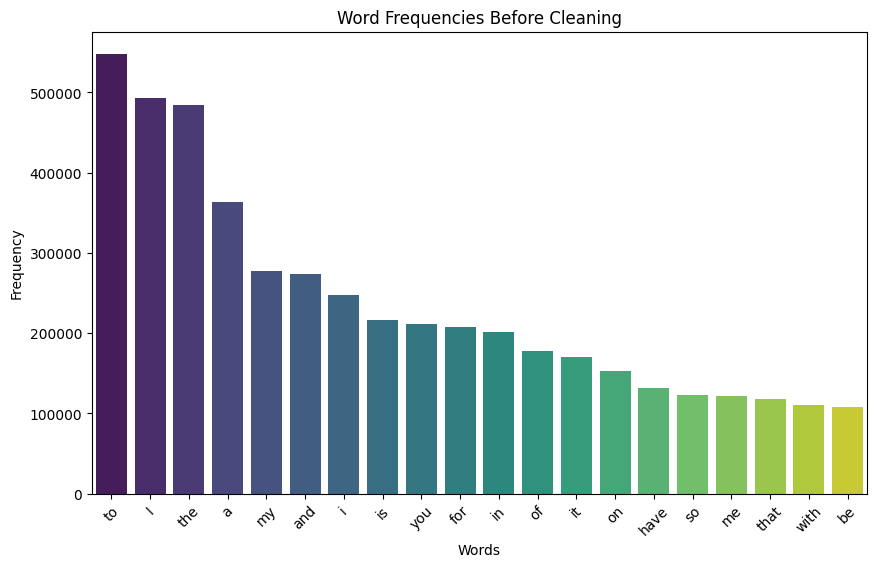

In [28]:
plot_word_frequencies(' '.join(df['text']), 'Word Frequencies Before Cleaning')

There are words without much meaning. We need to clean them 

## Cleaning

In [29]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /opt/app-
[nltk_data]     root/src/nltk_data...


True

In [30]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern       = '@[^\s]+'
alphaPattern      = "[^a-zA-Z]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

In [31]:
import re
#from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

#stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
    #tweet = re.sub(r"[^\w\s]|[\d]", "", tweet)
    #tweet = re.sub(r"https?://\S+", "", tweet) 
    #tweet = re.sub(r"@\w+|#", "", tweet)


def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = ' '.join([w for w in tweet.split(" ") if len(w) > 2])
    tweet = re.sub(urlPattern,'URL ',tweet)
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
    tweet = re.sub(userPattern, 'USER ', tweet)
    tweet = re.sub(alphaPattern, " ", tweet)
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
    tweet = " ".join([lemmatizer.lemmatize(word) for word in tweet.split() if word not in stop_words])
    return tweet

df['text'] = df["text"].apply(clean_tweet)

In [32]:
df['text']

0          USER URL aww bummer shoulda got david carr thi...
1          upset update facebook texting might cry result...
2          USER dived many time ball managed save rest bound
3                            whole body feel itchy like fire
4                                      USER behaving mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996          thewdb com cool hear old walt interview URL
1599997                       ready mojo makeover ask detail
1599998        happy th birthday boo time tupac amaru shakur
1599999                  happy charitytuesday USER USER USER
Name: text, Length: 1579241, dtype: object

Check for empty tweets after the cleaning process

In [33]:
empty_tweets = df[df['text'].apply(lambda x: len(x)==0)]
print(f"Number of empty tweets: {len(empty_tweets.index)}")

Number of empty tweets: 575


In [34]:
df = df.drop(empty_tweets.index)

In [35]:
print(f"Number of empty tweets: {len(df[df['text'].apply(lambda x: len(x)==0)].index)}")

Number of empty tweets: 0


/tmp/ipykernel_349/2346538814.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette='viridis')


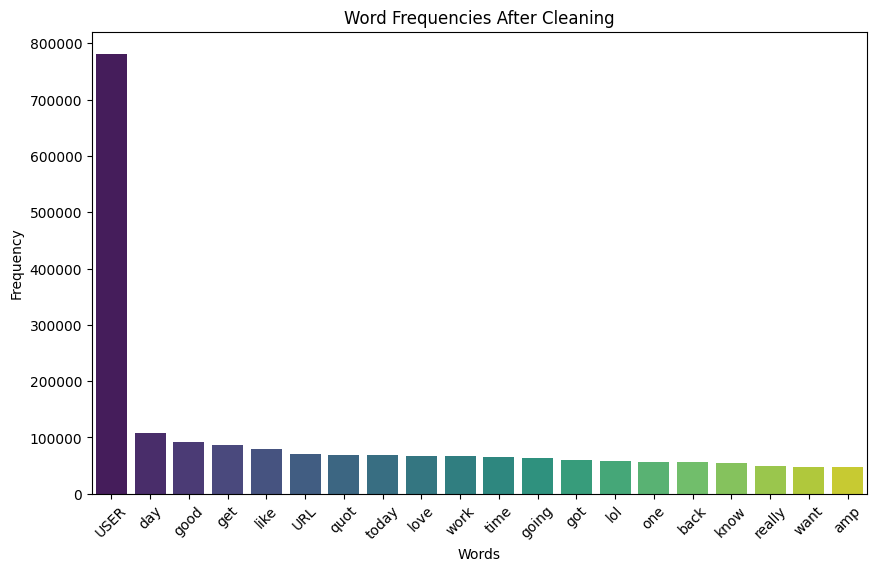

In [36]:
plot_word_frequencies(' '.join(df['text']), 'Word Frequencies After Cleaning')

/tmp/ipykernel_349/2346538814.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette='viridis')


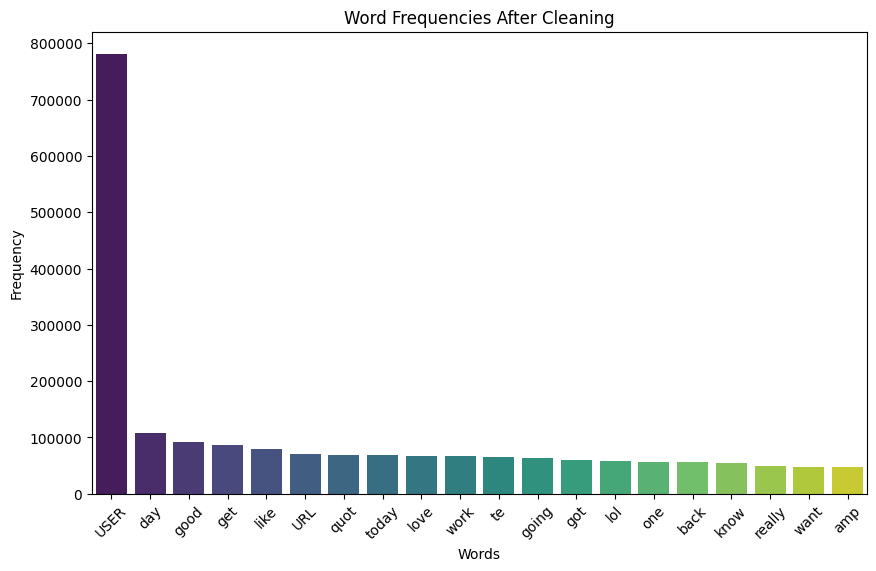

In [37]:
test = ' '.join([w.replace("im", "") for w in df['text']])
plot_word_frequencies(test, 'Word Frequencies After Cleaning')

In [38]:
df['text'] = df['text'].apply(lambda x: x.replace("im", ""))

In [39]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

positive_words = " ".join(df[df["target"] == 1]["text"])
negative_words = " ".join(df[df["target"] == 0]["text"])

wordcloud_postitive = WordCloud(width=800, height=400, background_color="white").generate(positive_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color="white").generate(negative_words)



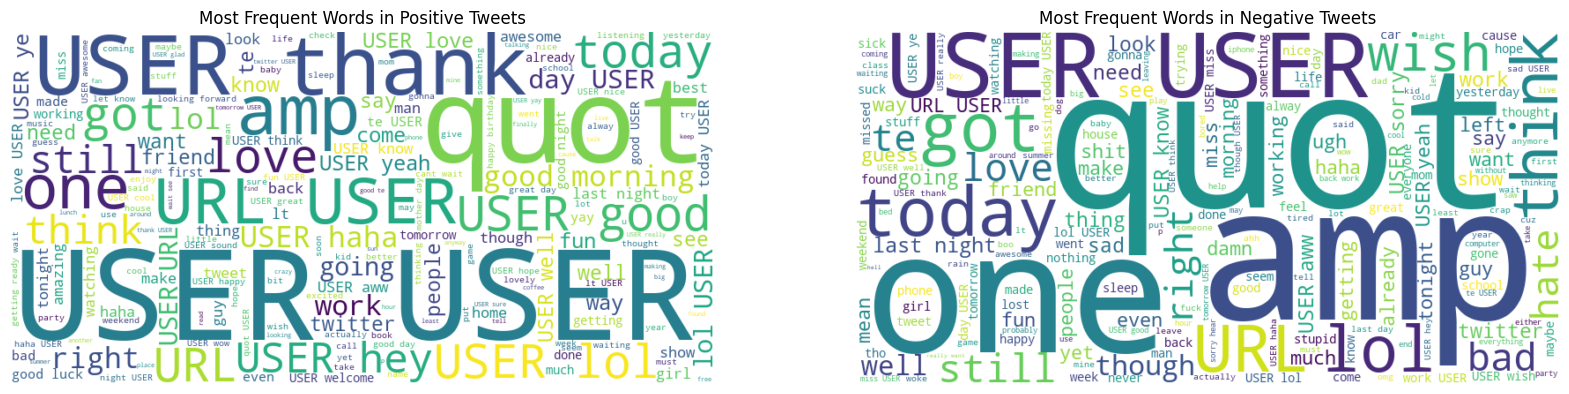

In [40]:

fig, axes = plt.subplots(1, 2, figsize=(20, 30))
axes[0].imshow(wordcloud_postitive, interpolation="bilinear")
axes[0].set_title("Most Frequent Words in Positive Tweets")
axes[0].axis("off")
axes[1].imshow(wordcloud_negative, interpolation="bilinear")
axes[1].set_title("Most Frequent Words in Negative Tweets")
axes[1].axis("off")
plt.show()

In [41]:
df["tweet_length"] = df["text"].apply(lambda x: len(x.split()))
tweet_len = df.groupby(["target"]).agg(
   mean = ("tweet_length", "mean")
)
tweet_len = tweet_len.transpose()
tweet_len


target,0,1
mean,7.338687,7.250399


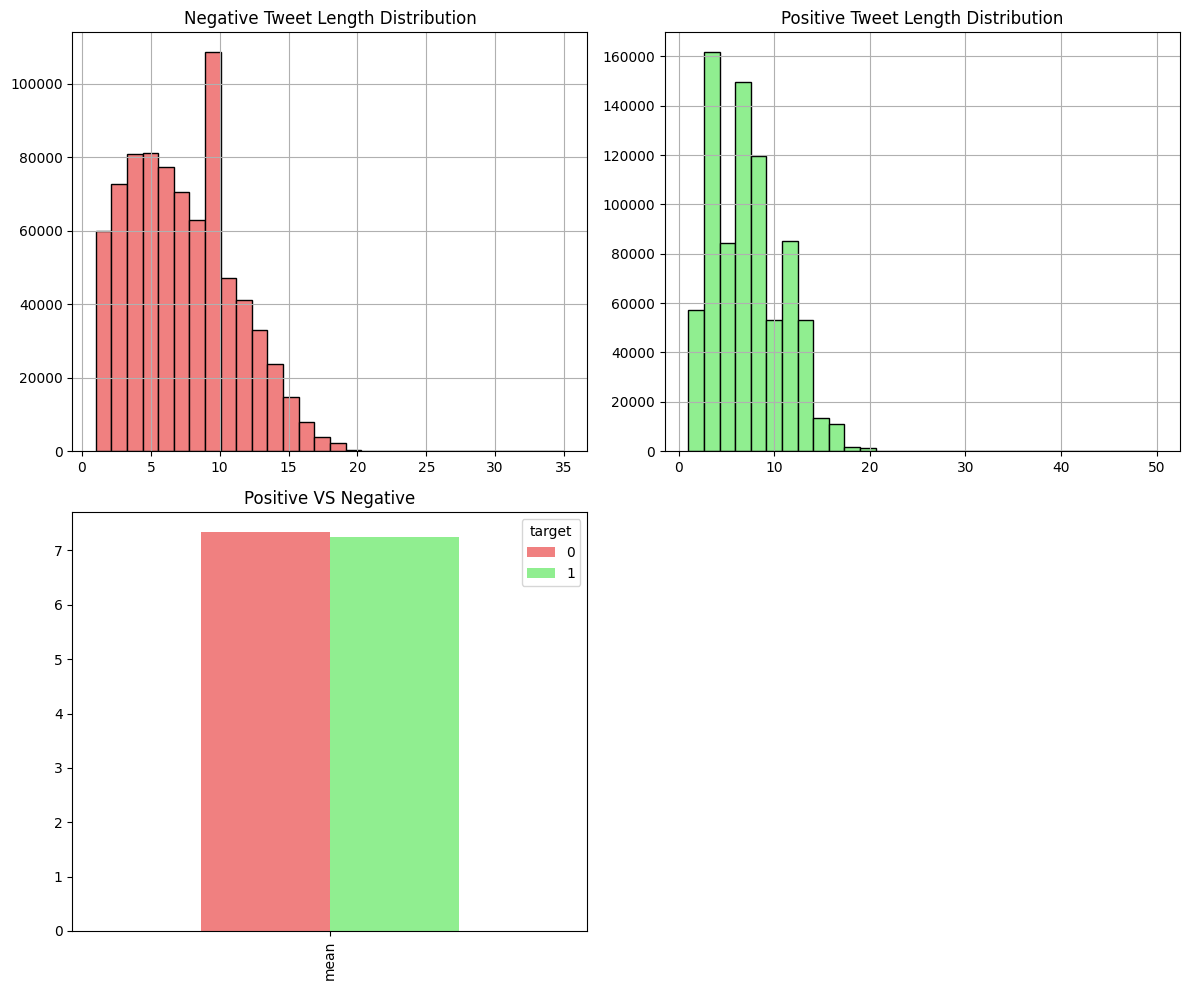

In [42]:

fig, axes = plt.subplots(2, 2, figsize=(12, 10))


df[df["target"]==0]["tweet_length"].hist(color="lightcoral", edgecolor="black", ax=axes[0, 0], bins=30)
df[df["target"]==1]["tweet_length"].hist(color="lightgreen", edgecolor="black", ax=axes[0, 1], bins=30)
tweet_len.plot(kind="bar", color = ("lightcoral", "lightgreen"), ax = axes[1, 0] )

axes[0, 0].set_title("Negative Tweet Length Distribution")
axes[0, 1].set_title("Positive Tweet Length Distribution")
axes[1, 0].set_title("Positive VS Negative")
fig.delaxes(axes[1,1])

plt.tight_layout()
plt.show()



## Save pre processing result

In [50]:
df.to_csv("preprocessed.csv", index=False)

In [51]:
s3_client.upload_file('preprocessed.csv', bucket_name, 'preprocessed.csv')